In [31]:
import mlflow
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pickle import dump

from hyperopt import STATUS_OK

from scripts.preprocessing_regression_models import Preprocess
from scripts.model_registry import ModelRegistry
from scripts.scoring import Scoring
from scripts.monitoring import Monitoring
from scripts.config_regression import (year_month_train,
    model_name_pref,
    input_data_path_train,
    local_path_save,
    seed)

In [ ]:
local_path_save = './local_artifacts_tmp/01_Linear_Regression/'

### MLFlow setting

In [2]:
if not os.path.exists(local_path_save):
    os.makedirs(local_path_save)

#save all metadata in a sqlite db. Artifacts will be saved on local folder ./mlflow    
mlflow.set_tracking_uri("sqlite:///mlflow.db")

# Name of the experiment
exp_name = "00 - Regression Baseline"
# set up MlFlow axperiment
experiment_id = mlflow.set_experiment(exp_name)

2023/01/02 10:34:52 INFO mlflow.tracking.fluent: Experiment with name '00 - Regression Baseline' does not exist. Creating a new experiment.


In [3]:
year_month = year_month_train
input_data_path = input_data_path_train

### Fitting and evaluation functions

In [4]:
def lr_evaluation(Y_train, Y_test, Y_pred_train, Y_pred_test):
        ''' 
        Function for evaluation of Linear Regression goodness
        '''
        rmse_train = mean_squared_error(Y_train,Y_pred_train)**0.5
        rmse_test = mean_squared_error(Y_test,Y_pred_test)**0.5
        
        mae_train = mean_absolute_error(Y_train, Y_pred_train)
        mae_test = mean_absolute_error(Y_test, Y_pred_test)
    
        return rmse_train, rmse_test, mae_train, mae_test

In [17]:
def objective_baseline(Y_train, Y_test, run_name: str = 'Unnamed'):
    '''
    Fitting function for Baseline
    '''
    with mlflow.start_run(run_name=run_name):
        mlflow.set_tag('model_type','Baseline')
        mlflow.set_tag('year_month',year_month)
        mlflow.log_param('model_type','Baseline')
        mlflow.log_param('data',input_data_path)

        average_y_train = Y_train.mean()

        Y_pred_train = np.repeat(average_y_train, Y_train.shape[0])
        Y_pred_test = np.repeat(average_y_train, Y_test.shape[0])
        rmse_train, rmse_test, mae_train, mae_test = lr_evaluation(
                Y_train, Y_test, Y_pred_train, Y_pred_test
        )

        mlflow.log_metrics({'rmse_train': rmse_train, 
                            'rmse_test': rmse_test,
                            'mae_train': mae_train,
                            'mae_test': mae_test})

        print('rmse_train = ', rmse_train, 
              '\n rmse_test', rmse_test,
              '\n mae_train', mae_train,
              '\n mae_test', mae_test)

        mlflow.log_artifact(local_path = local_path_save + run_name + '_ohe.pkl', artifact_path='preprocessing') 
        mlflow.sklearn.log_model(average_y_train, artifact_path='model')
    
    return {'loss': rmse_test, 'status': STATUS_OK}
    

## Experiments

In [ ]:
run_name = 'base'

In [7]:
prepr = Preprocess(input_data_path_train)
X, Y = prepr.read_dataframe(request_tgt=True)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=seed)

#preprocessing ohe
shapes_pre = (X_train.shape[0], X_test.shape[0])
X_train_ohe, ohe = prepr.preprocess(df=X_train, fit_ohe=True)
X_test_ohe, _ = prepr.preprocess(df=X_test, fit_ohe=False, ohe=ohe)
assert shapes_pre == (X_train.shape[0], X_test.shape[0])
dump(ohe, open(local_path_save + run_name + '_ohe.pkl', 'wb'))

df shape (3576, 20)


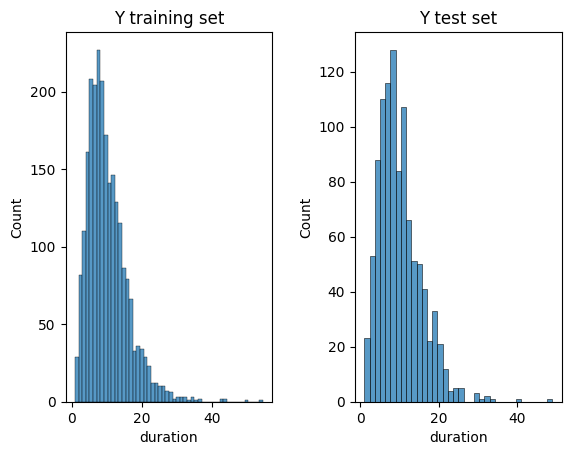

In [37]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
sns.histplot(Y_train,ax=ax).set_title('Y training set')
ax = fig.add_subplot(1, 2, 2)
sns.histplot(Y_test,ax=ax).set_title('Y test set')
plt.show()

In [39]:
Y_train.describe()

count    2398.000000
mean       10.286148
std         5.792443
min         1.000000
25%         6.187500
50%         9.100000
75%        13.145833
max        54.433333
Name: duration, dtype: float64

In [18]:
objective_baseline(Y_train=Y_train, Y_test=Y_test)

rmse_train =  5.791234966892877 
 rmse_test 5.487662729867075 
 mae_train 4.3753029120504685 
 mae_test 4.242818134221234


/Users/davideposillipo/.pyenv/versions/3.10.9/envs/mlops/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


{'loss': 5.487662729867075, 'status': 'ok'}